# Ridge regression

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ridge regression with Cross Validation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import Ridge

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
k_folds = 7
lambda_ridge = 0.1
MSE_test_list = [] 
MSE_train_list = []
MSE_skl_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) #number of data points
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for k in tqdm.tqdm(range(k_folds)): 
    MSE_test = []
    MSE_train = []
    MSE_skl = []
    
    # extract folds
    xyz_test = xyz_folds[k]
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(
            degree=poly_deg), Ridge_skl(alpha=lambda_ridge, fit_intercept=False))
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge)
        
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) #tester modellen på test
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel())) # tester på fit
        
        #sklearn:
        z_pred = model_skl.fit(xy_train, z_train.reshape(-1, 1)).predict(xy_test)
        MSE_skl.append(np.mean((z_pred.ravel() - z_test.ravel())**2)) # tester modellen mot
        
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_skl_list.append(MSE_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_skl_list = np.array(MSE_skl_list)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
test_skl_avrg = np.mean(MSE_skl_list, axis=0)

100%|██████████| 7/7 [00:01<00:00,  3.68it/s]


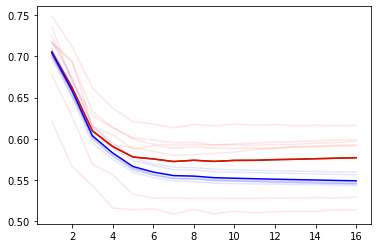

In [9]:
for i in range(len(MSE_test_list)):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 
    #plt.plot(range(1, len(MSE_test)+1), MSE_skl_list[i], 'r', alpha=0.1)

plt.plot(range(1, len(MSE_test)+1), test_skl_avrg, 'g')
plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
#plt.plot(range(1, len(variance_avrg)+1), variance_avrg, 'g')

plt.show()
# Observasjonar: 
# Larger lambda_ridge forces MSE test to flatten out and not explode. 

## Ridge Regression with bootstrap
In this example I study whether I am able to simulate uncertainty in beta using bootstrap resampling. The result is compared to the analythical expression for uncertainty in bootstrap. In order to get visible confidence intervals it is necessary to use a small lambda. 

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import Ridge

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 18
n_bootstraps = 100
lambda_ridge = 0.1 
MSE_test_list = [] 
MSE_train_list = []
MSE_skl_list = [] #test
predict_train_list = []
betas_list = []
var_betas_list = []
predict_train_skl_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

xy_train, xy_test, z_train, z_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.5)
for n in tqdm.tqdm(range(n_bootstraps)): 
    MSE_test = []
    MSE_train = []
    MSE_skl = [] #test
    predict_train = []
    predict_train_skl = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    var_beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = Ridge(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, lambda_ridge)
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test)) 
        MSE_train.append(model.MSE(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel())) # orig model.
        
        beta_poly[poly_deg-1, 0:int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
        var_beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(
            model.var_beta(xy_test[:, 0], xy_test[:, 1], z_test))
        var_beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
        predict_train.append(model.predict(xy_samp[:, 0], xy_samp[:, 1]).ravel())# predicted model
        
        #SKlearn
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Ridge_skl(
            alpha=lambda_ridge, fit_intercept=False))
        z_pred = model_skl.fit(xy_samp, z_samp.reshape(-1, 1)).predict(xy_test)
        MSE_skl.append(np.mean((z_pred.ravel() - z_test.ravel())**2)) 
        
        
    # store all values for averaging
    MSE_test_list.append(MSE_test) 
    MSE_train_list.append(MSE_train)
    MSE_skl_list.append(MSE_skl)
    predict_train_list.append(predict_train)
    betas_list.append(beta_poly) 
    var_betas_list.append(var_beta)
    predict_train_skl_list.append(predict_train_skl)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)
MSE_skl_list = np.array(MSE_skl_list)
predict_train_list = np.array(predict_train_list)
predict_train_skl_list = np.array(predict_train_skl_list)
betas_list = np.array(betas_list, dtype=object)
var_betas_list = np.array(var_betas_list, dtype=object)

#study average values
test_pol_avrg = np.mean(MSE_test_list, axis=0) 
train_pol_avrg = np.mean(MSE_train_list, axis=0)
test_skl_avrg = np.mean(MSE_skl_list, axis=0)
var_betas = np.mean(var_betas_list, axis=0) 
mean_betas_bootstrap = np.mean(betas_list, axis=0) 
var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


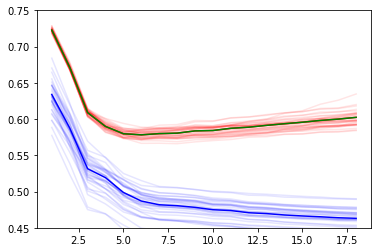

In [28]:
for i in range(0, len(MSE_test_list), 3):
    plt.plot(range(1, len(MSE_test)+1), MSE_test_list[i], 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train_list[i], 'b', alpha=0.1) 

plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_train)+1), train_pol_avrg, 'b')
plt.plot(range(1, len(MSE_test)+1), test_skl_avrg, 'g')

plt.ylim(0.45, 0.75)
plt.show()

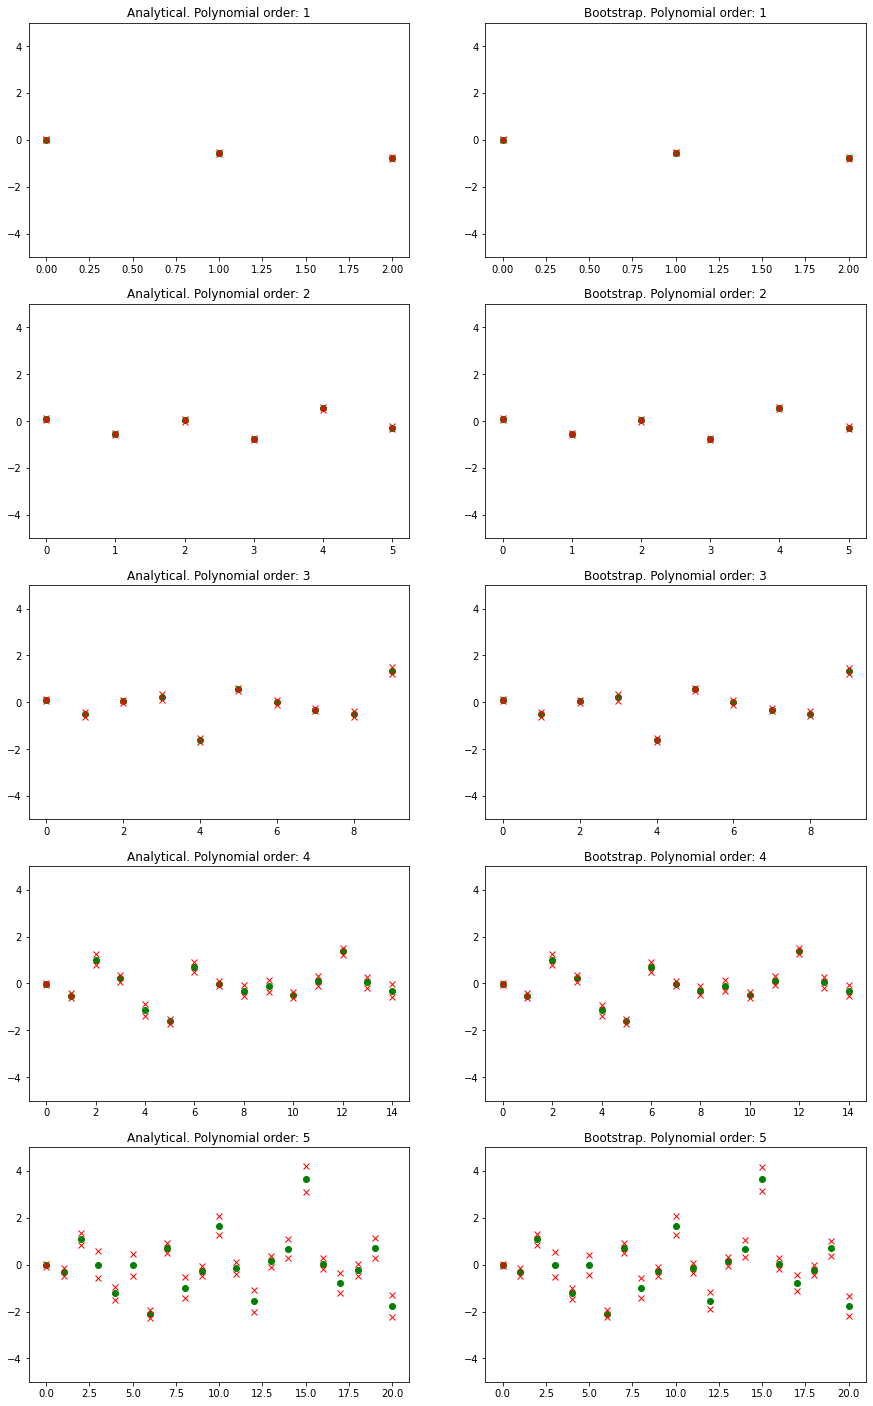

In [29]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 2, figsize=(15, 25), facecolor='w', edgecolor='k')
#axs = axs.ravel()

sigma = 1
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(var_betas[
            polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 0].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(var_betas[
            polynom_nr][beta_nr_i]), 'rx') 
        
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 1].plot(beta_nr_i, mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx')         

    axs[polynom_nr, 0].set_title('Analytical. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 0].set_ylim([-5, 5])
    axs[polynom_nr, 1].set_title('Bootstrap. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 1].set_ylim([-5, 5])
plt.show()

### Observations: 
- My own and SklLearns implementation of Ridge gives similar results for large values of lambda. But if lambda is too low it seems like MSE_train raises faster for my own implementation than for sKlearn. This could be due to the fact that my own implementation og Ridge is more exposed to numeric errors. 
- If lambda increases, 
    - MSE_train converges as expected. 
    - MSE in optimum increases
    - Spread in beta values and their standard deviation decreases. 
    
- The more bootstraps, the more precise estimate of variance in beta. 
- The problem with over-fitting seems to be that one beta cancel out another beta in order to adapt the model to noise. By increasing lambda we punish spread in beta values. This corresponds to shrinking small eigenvalues more than large eigenvalues, making the most important features more important. 
- Make a figure of spread in beta (vertical) and different choices of lambda (horisontal) 

# Plot of beta values for different lambdas! 
Here I study how increasing lambda affects the spread in beta values. 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# my own library
from regression import Ridge

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

poly = 18
n_bootstraps = 100


lambda_ridge = 0.0001
betas_list = []
var_betas_list = []

xy_train, xy_test, z_train, z_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.5)
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    var_beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = Ridge(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, lambda_ridge)
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel())
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        var_beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(
            model.var_beta(xy_test[:, 0], xy_test[:, 1], z_test))
        var_beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan        
        
    # store all values for averaging
    betas_list.append(beta_poly) 
    var_betas_list.append(var_beta)

betas_list = np.array(betas_list, dtype=object)
var_betas_list = np.array(var_betas_list, dtype=object)

#var_betas = np.mean(var_betas_list, axis=0) 
l1_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l1_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta



lambda_ridge = 1
betas_list = []
var_betas_list = []

xy_train, xy_test, z_train, z_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.5)
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    var_beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = Ridge(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, lambda_ridge)
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        var_beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(
            model.var_beta(xy_test[:, 0], xy_test[:, 1], z_test))
        var_beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan        
        
    # store all values for averaging
    betas_list.append(beta_poly) 
    var_betas_list.append(var_beta)

betas_list = np.array(betas_list, dtype=object)
var_betas_list = np.array(var_betas_list, dtype=object)

#var_betas = np.mean(var_betas_list, axis=0) 
l2_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l2_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta

lambda_ridge = 100
betas_list = []
var_betas_list = []

xy_train, xy_test, z_train, z_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                        z_cent, test_size=0.5)
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    var_beta = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        # fit own model
        model = Ridge(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg, lambda_ridge)
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        var_beta[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.var_beta(
            xy_test[:, 0], xy_test[:, 1], z_test))
        var_beta[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan        
        
    # store all values for averaging
    betas_list.append(beta_poly) 
    var_betas_list.append(var_beta)

betas_list = np.array(betas_list, dtype=object)
var_betas_list = np.array(var_betas_list, dtype=object)

#var_betas = np.mean(var_betas_list, axis=0) 
l3_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l3_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


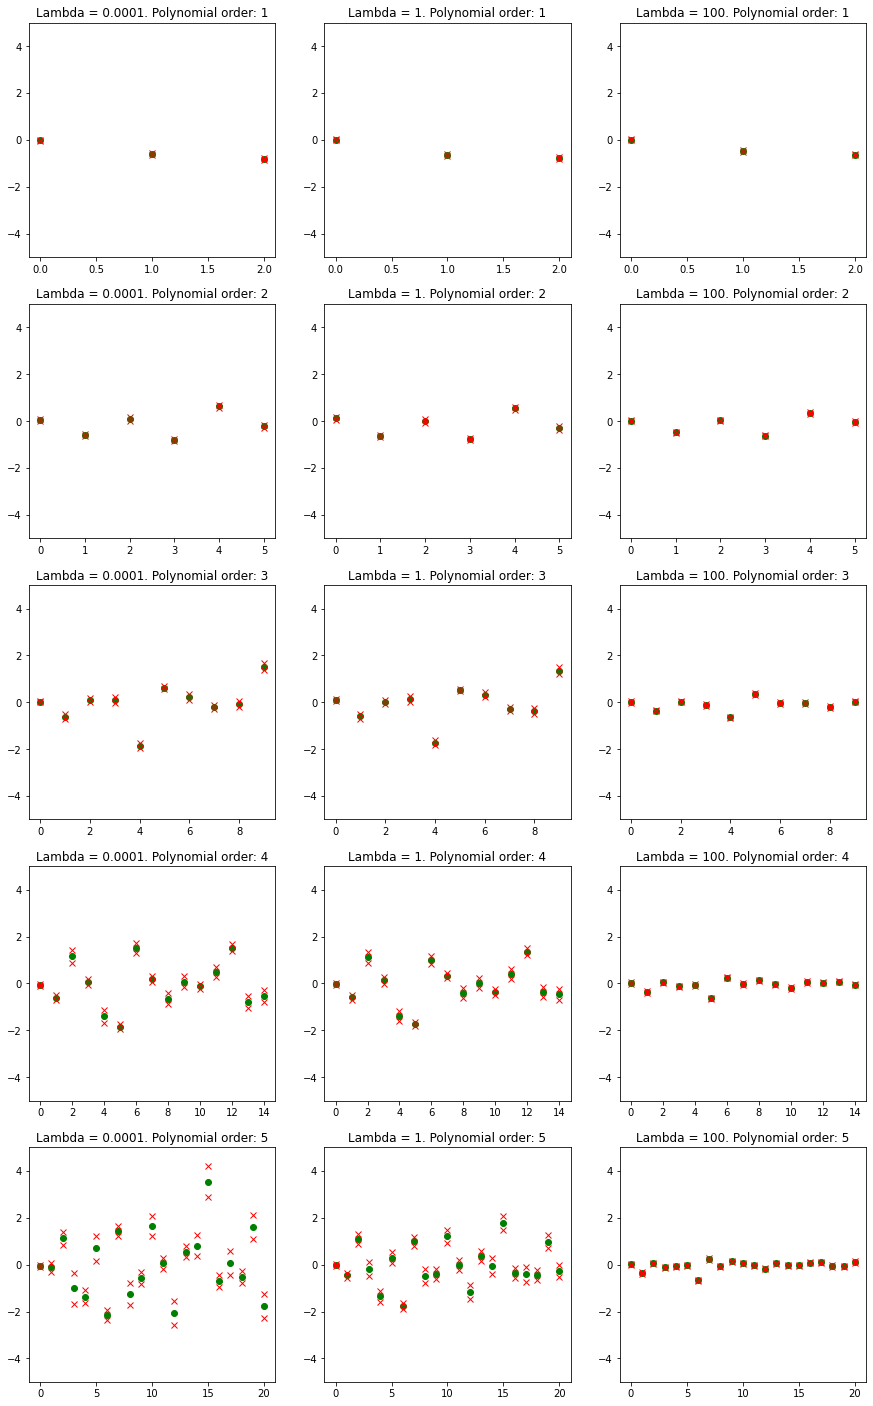

In [31]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 3, figsize=(15, 25), facecolor='w', edgecolor='k')
#axs = axs.ravel()

sigma = 1
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l1_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l1_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l2_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l2_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l3_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l3_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx')   

    axs[polynom_nr, 0].set_title('Lambda = 0.0001. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 0].set_ylim([-5, 5])
    axs[polynom_nr, 1].set_title('Lambda = 1. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 1].set_ylim([-5, 5])
    axs[polynom_nr, 2].set_title('Lambda = 100. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 2].set_ylim([-5, 5])
plt.show()

In the plot above we can clearly see that increasing the polynomial order increases the beta values variance. The variance is increased for single beta-values and for the total spread of all beta values. Increasing lambda dampens this spread, pushing the beta coefficients towards zero. In fact, according to lecture notes increasing lambda ammounts to tightening the confidence interval of beta. 